# Ellipses Project (Dvir Samuel)

## Data Preprocessing

In [0]:
import numpy as np
from numpy import genfromtxt
from PIL import Image
import pandas as pd
from collections import Counter
import keras
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Concatenate, Add
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras import backend as K
from keras.utils import plot_model
from keras.optimizers import Adam,Nadam,SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
%matplotlib inline

In [0]:
# Load train data
train_data = pd.read_csv("images/train_data.txt",delimiter=", ",header=0, engine='python')
# organazie the data and seperate to different dataframes
seperated_col = train_data[train_data.columns[0]].str.partition(" ")[[0,2]]
X_train_images = seperated_col[[0]].rename(columns = {0:'paths'})
Y_train_class = seperated_col[[2]].rename(columns = {2:'class'})
del train_data[train_data.columns[0]]
Y_train_features = train_data

##### Training images paths

In [285]:
X_train_images.head()

,paths
0,images/train/0000.jpg
1,images/train/0001.jpg
2,images/train/0002.jpg
3,images/train/0003.jpg
4,images/train/0004.jpg


##### Training true labels - ellipse or not

In [286]:
Y_train_class.head()

,class
0,False
1,True
2,False
3,False
4,True


##### Training true features - ellipse parameters

In [287]:
Y_train_features.head()

,center_x,center_y,angle,axis_1,axis_2
0,0,0,0,0,0
1,34,32,25,16,17
2,0,0,0,0,0
3,0,0,0,0,0
4,18,19,150,20,15


In [0]:
# Load test data
test_data = pd.read_csv("images/test_data.txt",delimiter=", ",header=0, engine='python')
# organazie the data and seperate to different dataframes
seperated_col = test_data[test_data.columns[0]].str.partition(" ")[[0,2]]
X_test_images = seperated_col[[0]].rename(columns = {0:'paths'})
Y_test_class = seperated_col[[2]].rename(columns = {2:'class'})
del test_data[test_data.columns[0]]
Y_test_features = test_data

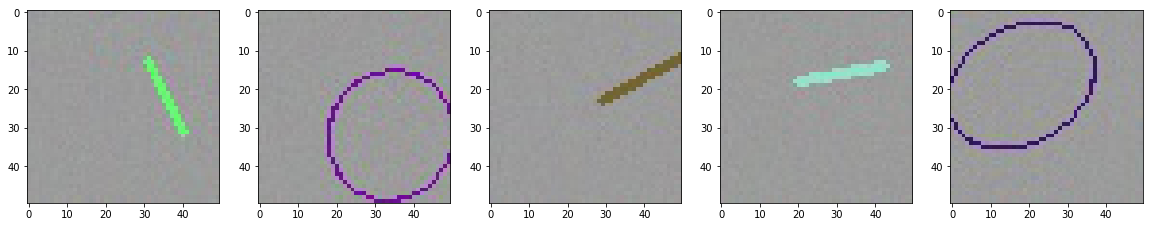

In [289]:
# show some data samples
fig = plt.figure(figsize=(20,20))
for idx,path in enumerate(X_train_images['paths'].head()):
    img = Image.open(path)
    fig.add_subplot(1,5,idx+1)
    plt.imshow(img)

##### More preprocessing (data reordering and image normalization)

* Normalize the angles - If angles are greater than 180 degrees we can normalize them

In [0]:
Y_train_features['angle'] = Y_train_features['angle']%180
Y_test_features['angle'] = Y_test_features['angle']%180

* We would like to constrain the features so that the angle will allways be the ratio between the long axis and the x_axis now, it is just the ratio between the first axis and the x axis (as we can see in the images), so we make sure that the long axis is the first axis (axis_1) and the angle is adjusted accordingly.

In [291]:
# For TRAIN
# check where axis_1 is smaller than axis_2
indices = np.where(Y_train_features['axis_1'] < Y_train_features['axis_2'])[0]
print("Before:")
display(Y_train_features.loc[indices].head())
# swap axis_1 with axis_2
tmp = Y_train_features.loc[indices,'axis_1']
Y_train_features.loc[indices,'axis_1'] = Y_train_features.loc[indices,'axis_2']
Y_train_features.loc[indices,'axis_2'] = tmp
# rotate angle by 90
Y_train_features.loc[indices,'angle'] = (Y_train_features.loc[indices,'angle']+90)%180
print("After:")
display(Y_train_features.loc[indices].head())

# For TEST
# check where axis_1 is smaller than axis_2
indices = np.where(Y_test_features['axis_1'] < Y_test_features['axis_2'])[0]
# swap axis_1 with axis_2
tmp = Y_test_features.loc[indices,'axis_1']
Y_test_features.loc[indices,'axis_1'] = Y_test_features.loc[indices,'axis_2']
Y_test_features.loc[indices,'axis_2'] = tmp
# rotate angle by 90
Y_test_features.loc[indices,'angle'] = (Y_test_features.loc[indices,'angle']+90)%180

Before:


,center_x,center_y,angle,axis_1,axis_2
1,34,32,25,16,17
9,20,19,81,15,16
10,26,27,61,15,24
15,26,28,177,15,18
16,24,25,160,4,13


After:


,center_x,center_y,angle,axis_1,axis_2
1,34,32,115,17,16
9,20,19,171,16,15
10,26,27,151,24,15
15,26,28,87,18,15
16,24,25,70,13,4


In [292]:
# load train images to memory
X_train_o = np.array([np.array(Image.open(path)) for path in X_train_images['paths']]).astype('float32')
X_test_o = np.array([np.array(Image.open(path)) for path in X_test_images['paths']]).astype('float32')
print("Train shape:", X_train_o.shape)
print("Test shape:", X_test_o.shape)

Train shape: (10000, 50, 50, 3)
Test shape: (1000, 50, 50, 3)


In [0]:
# normalize rgb images
X_train = X_train_o / 255
X_test = X_test_o / 255
# y to one-hote encoding
Y_train_class['class'] = (Y_train_class['class'].values == 'True').astype(float)
Y_test_class['class'] = (Y_test_class['class'].values == 'True').astype(float)

## Data Distribuation
### Check if data is balanced

In [294]:
print("Train Data:")
print(Counter(Y_train_class['class']))
print("Test Data")
print(Counter(Y_test_class['class']))

Train Data:
Counter({1.0: 6997, 0.0: 3003})
Test Data
Counter({1.0: 688, 0.0: 312})


As we can see, there are more ellipses than non-ellipses (greater by almost 2.4) - in training we will give all non ellipses data more weight

In [295]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(Y_train_class), Y_train_class["class"])
class_weights = {cid : weight for cid, weight in enumerate(class_weights)}
print(class_weights)

{0: 1.665001665001665, 1: 0.7145919679862799}


## Approach 1: Image Processing method 
  #### I will try first to see if we could get reasonable results using opencv with traditional image processing methods

I tried playing with contour and fitEllipse, but it did not give good results.
Most of the time it couldn't find the ellipses if they where drawn in the image..

## Approach 2: Deep Learning method 
#### I will try and implement a cnn network which outputs True/False if , and the features

In [296]:
# build the model
inputs = Input(shape=X_train.shape[1:])
conv1 = Conv2D(32, (3, 3), padding='same', name='conv1')(inputs)
bn1 = BatchNormalization(axis=3,name='bn1')(conv1)
act1 = Activation('relu',name='act1')(bn1)
mp1 = MaxPooling2D(padding='same',name='mp1')(act1)
conv2 = Conv2D(64, (3, 3), padding='same',name='conv2')(mp1)
bn2 = BatchNormalization(axis=3,name='bn2')(conv2)
act2 = Activation('relu',name='act2')(bn2)
conv3 = Conv2D(64, (3, 3), padding='same',name='conv3')(act2)
conv4 = Conv2D(64, (1,1),name='conv4')(mp1)
add1 = Add(name='add1')([conv3, conv4])
bn3 = BatchNormalization(axis=3,name='bn3')(add1)
act3 = Activation('relu',name='act3')(bn3)
conv5 = Conv2D(128, (3, 3), padding='same', strides=(2,2),name='conv5')(act3)
bn4 = BatchNormalization(axis=3,name='bn4')(conv5)
act4 = Activation('relu',name='act4')(bn4)
conv6 = Conv2D(128, (3, 3), padding='same',name='conv6')(act4)
conv7 = Conv2D(128, (1,1), strides=(2,2),name='conv7')(add1)
add2 = Add(name='add2')([conv6, conv7])
bn5 = BatchNormalization(axis=3,name='bn5')(add2)
act5 = Activation('relu',name='act5')(bn5)
flat1 = Flatten(name='flat1')(act5)
dense1 = Dense(512,name='dense1')(flat1)
bn6 = BatchNormalization(name='bn6')(dense1)
act6 = Activation('relu',name='act6')(bn6)
do1 = Dropout(0.2,name='do1')(act6)
dense2 = Dense(1,name='dense2')(do1)
classification = Activation('sigmoid', name = 'class')(dense2)
dense3 = Dense(5,name='dense3')(do1)
features = Activation('relu',name='features')(dense3)

model = Model(inputs=inputs, outputs=[classification,features])

model.summary()
plot_model(model, to_file="model.png")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           (None, 50, 50, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 50, 32)   896         input_27[0][0]                   
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 50, 50, 32)   128         conv1[0][0]                      
__________________________________________________________________________________________________
act1 (Activation)               (None, 50, 50, 32)   0           bn1[0][0]                        
__________________________________________________________________________________________________
mp1 (MaxPo

Model structure:


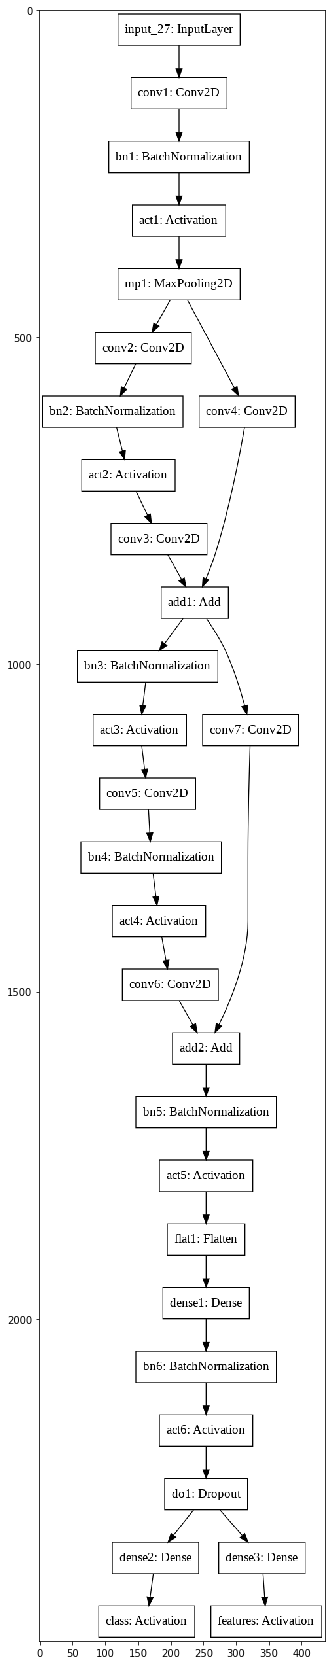

In [297]:
print("Model structure:")
fig = plt.figure(figsize=(25,30))
model_img = Image.open("model.png")
plt.imshow(model_img)

#### Model training

In [0]:
# hyperparams
epochs = 40
batch_size = 64
optAlgo = Adam()

# compile model
model.compile(optAlgo,loss=['binary_crossentropy','mse'], metrics=['accuracy'],loss_weights=[1.,.01])

# values to track:
save_to = 'best_model.h5'
checkpoint = ModelCheckpoint(filepath=save_to,verbose=0, save_best_only=True)
callbacks = [checkpoint]

In [299]:
# train model
history = model.fit(X_train, [Y_train_class,Y_train_features], shuffle=True, batch_size=batch_size, 
                             epochs=epochs, verbose=1, validation_split=0.3, callbacks = callbacks)

Train on 7000 samples, validate on 3000 samples
Epoch 1/40
7000/7000 [==============================] - 17s 2ms/step - loss: 10.7115 - class_loss: 0.1632 - features_loss: 1054.8296 - class_acc: 0.9454 - features_acc: 0.5676 - val_loss: 14.2705 - val_class_loss: 2.2843 - val_features_loss: 1198.6113 - val_class_acc: 0.7083 - val_features_acc: 0.2253
Epoch 2/40
7000/7000 [==============================] - 8s 1ms/step - loss: 3.9825 - class_loss: 0.0492 - features_loss: 393.3290 - class_acc: 0.9840 - features_acc: 0.7173 - val_loss: 14.1802 - val_class_loss: 2.3259 - val_features_loss: 1185.4259 - val_class_acc: 0.6370 - val_features_acc: 0.6567
Epoch 3/40
7000/7000 [==============================] - 8s 1ms/step - loss: 2.0404 - class_loss: 0.0336 - features_loss: 200.6773 - class_acc: 0.9911 - features_acc: 0.8017 - val_loss: 29.1660 - val_class_loss: 11.3739 - val_features_loss: 1779.2139 - val_class_acc: 0.2943 - val_features_acc: 0.3447
Epoch 4/40
7000/7000 [==========================

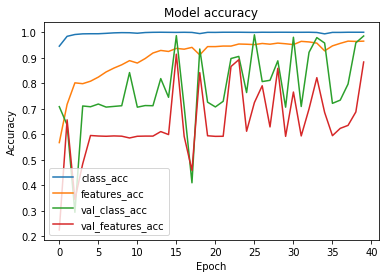

In [300]:
# Plot training & validation accuracy values
plt.plot(history.history['class_acc'])
plt.plot(history.history['features_acc'])
plt.plot(history.history['val_class_acc'])
plt.plot(history.history['val_features_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['class_acc','features_acc','val_class_acc', 'val_features_acc'], loc='lower left')
plt.show()

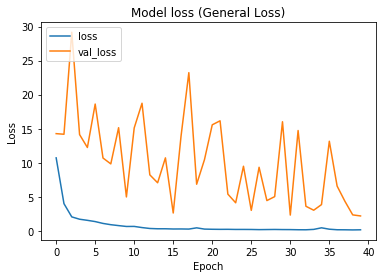

In [301]:
# Plot training & validation loss values (general loss)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss (General Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss','val_loss'], loc='upper left')
plt.show()

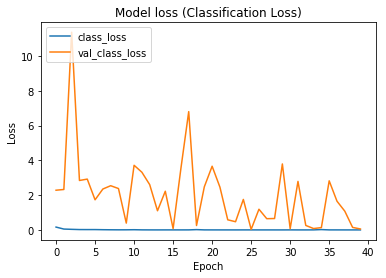

In [302]:
# Plot training & validation loss values (classification loss)
plt.plot(history.history['class_loss'])
plt.plot(history.history['val_class_loss'])
plt.title('Model loss (Classification Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['class_loss','val_class_loss'], loc='upper left')
plt.show()

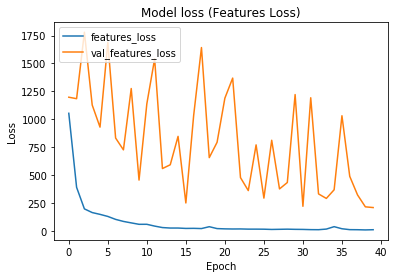

In [303]:
# Plot training & validation loss values (features loss)
plt.plot(history.history['features_loss'])
plt.plot(history.history['val_features_loss'])
plt.title('Model loss (Features Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['features_loss','val_features_loss'], loc='upper left')
plt.show()

#### Model evaluation

In [304]:
# load best model wights
model.load_weights(save_to)
# loss,features_l,ellipses_l,featres_a,ellipses_a
_,_,_,acc_classes,acc_features = model.evaluate(X_test, [Y_test_class,Y_test_features])
print('Test Features Acc:', acc_features)
print('Test Classification Acc:', acc_classes)

1000/1000 [==============================] - 0s 472us/step
Test Features Acc: 0.884
Test Classification Acc: 0.985


In [305]:
# Check errors
features_predicted = model.predict(X_test)[1]
for feat,error in zip(["center_x","center_y","angle","axis_1","axis_2"],
                      (pd.DataFrame(features_predicted) - Y_test_features.values).abs().mean()):
    if feat == "angle":
        continue #we will evaluate error later...
    print(feat,"avg error:",error,"pixels")

# check error percentages for angle
predictions = pd.DataFrame(features_predicted)
ellipses_idx = np.where(Y_test_class['class'] == 1)[0]
angle_idx = Y_test_features.columns.get_loc("angle")
true_angles = Y_test_features.loc[ellipses_idx,"angle"]
predicted_angles = predictions.loc[ellipses_idx,predictions.columns[angle_idx]]
err_percentages = (((true_angles - predicted_angles).abs() +180)%360 - 180)/true_angles
print("Avg angle error:", np.mean(err_percentages[err_percentages != np.inf]))

center_x avg error: 1.8570883169025183 pixels
center_y avg error: 2.303380348563194 pixels
axis_1 avg error: 1.9274096487760544 pixels
axis_2 avg error: 1.2748347750008107 pixels
Avg angle error: 0.9684823016923735
